# Delay discounting task

<center>
    <figure>
        <img src="./images/dd-thumbnail.png"
             width="500px">
        <figcaption>Overview of the delay discounting task.</figcaption>
    </figure>
</center>

## 1. Initialization

### 1) Task: Delay discounting task

- **Design variables**
    - `t_ss` ($t_{SS}$): Delay for the SS (smaller, sooner) option
    - `t_ll` ($t_{LL}$): Delay for the LL (larger, later) option
        - The delay on SS option should be sooner than that of LL option ($t_{SS} < t_{LL}$).
    - `r_ss` ($R_{SS}$): Reward value for the SS (smaller, sooner) option
    - `r_ll` ($R_{LL}$): Reward value for the LL (larger, later) option
        - The reward on SS option should be smaller than that of LL option ($R_{SS} < R_{LL}$).
- **Possible responses**:
    - `choice`: `0` (SS option), `1` (LL option)

In [1]:
from adopy.tasks.dd import TaskDD

task = TaskDD()

In [2]:
task.name

'Delay discounting task'

In [3]:
task.designs

['t_ss', 't_ll', 'r_ss', 'r_ll']

In [4]:
task.responses

['choice']

### 2) Model: Hyperbolic model (Mazur, 1987)

$$
\begin{aligned}
    \text{discounting factor} \; D(t) &= \frac{1}{1 + kt} \\
    V_{SS} &= R_{SS} \cdot D(t_{SS}) \\
    V_{LL} &= R_{LL} \cdot D(t_{LL}) \\
    P(LL \, over \, SS) &= \frac{1}{1 + \exp [- \tau \cdot \gamma (V_{LL} - V_{SS})]}
\end{aligned}
$$

- **Model parameters**
    - `k` ($k$): discounting rate parameter
    - `tau` ($\tau$): inverse temperature

In [5]:
from adopy.tasks.dd import ModelHyp

model = ModelHyp()

In [6]:
model.name

'Hyperbolic model for the DD task'

In [7]:
model.params

['k', 'tau']

### 3) Grid definition

#### Grid for design variables

In [8]:
import numpy as np

grid_design = {
    # [Now]
    't_ss': [0],
    # [3 days, 5 days, 1 week, 2 weeks, 3 weeks,
    #  1 month, 6 weeks, 2 months, 10 weeks, 3 months,
    #  4 months, 5 months, 6 months, 1 year, 2 years,
    #  3 years, 5 years, 10 years] in a weekly unit
    't_ll': [0.43, 0.714, 1, 2, 3,
             4.3, 6.44, 8.6, 10.8, 12.9,
             17.2, 21.5, 26, 52, 104,
             156, 260, 520],
    # [$12.5, $25, ..., $775, $787.5]
    'r_ss': np.arange(12.5, 800, 12.5),
    # [$800]
    'r_ll': [800]
}

#### Grid for model parameters

In [9]:
grid_param = {
    # 50 points on [10^-5, ..., 1] in a log scale
    'k': np.logspace(-5, 0, 50, base=10),
    # 10 points on (0, 5] in a linear scale
    'tau': np.linspace(0, 5, 11)[1:]
}

#### Grid for response variables

In [10]:
grid_response = {
    'choice': [0, 1]
}

### 4) Engine initialization

In [11]:
from adopy import Engine

engine = Engine(task, model, grid_design, grid_param, grid_response)

In [12]:
# Posterior means (k, tau)
engine.post_mean

k      0.095512
tau    2.750002
Name: Posterior mean, dtype: float32

In [13]:
# Standard deviations for the posterior distribution (k, tau)
engine.post_sd

k      0.210282
tau    1.436141
Name: Posterior SD, dtype: float32

## 2. Design comparison

1. **ADO design**
2. **Fixed design** (Green & Myerson, 2004)
    - The staircase method runs 6 trials for each delay to estimate the discounting rate. While $t_{SS}$ is fixed to 0, it starts with $R_{SS}$ of \\$400 and $R_{LL}$ of \\$800. If a participant chooses the SS option, the staircase method increases $R_{SS}$ by 50\%; if the participant chooses the LL option, it decreases $R_{SS}$ by 50\%. After repeating this 5 times, it proceeds to another delay value.
3. **Random design**

In [14]:
N_TRIAL = 42

In [15]:
# 1 week, 2 weeks, 1 month, 6 months, 1 year, 2 years, 10 years
D_CAND = [1, 2, 4.3, 26, 52, 104, 520]

# DELTA_R_SS for the staircase method:
# The amount of changes on R_SS every 6 trials.
DELTA_R_SS = [400, 200, 100, 50, 25, 12.5]

### Functions

#### Simulate a response

In [16]:
# True parameter values to simulate responses
PARAM_TRUE = {'k': 0.12, 'tau': 1.5}

In [17]:
from scipy.stats import bernoulli

def get_simulated_response(design):
    # Calculate the probability to choose a variable option
    t_ss, t_ll, r_ss, r_ll = (
        design['t_ss'], design['t_ll'],
        design['r_ss'], design['r_ll']
    )
    k, tau = PARAM_TRUE['k'], PARAM_TRUE['tau']
    
    u_ss = r_ss * (1. / (1 + k * t_ss))
    u_ll = r_ll * (1. / (1 + k * t_ll))
    p_obs = 1. / (1 + np.exp(-tau * (u_ll - u_ss)))

    # Randomly sample a binary choice response from Bernoulli distribution
    return bernoulli.rvs(p_obs)

### Simulation

In [18]:
import pandas as pd

# Make an empty DataFrame to store data
columns = ['design_type', 'trial', 'mean_k', 'mean_tau', 'sd_k', 'sd_tau']
df_simul = pd.DataFrame(None, columns=columns)

# Run simulations for three designs
for design_type in ['ADO', 'staircase', 'random']:
    # Reset the engine as an initial state
    engine.reset()
    
    d_staircase = D_CAND
    np.random.shuffle(d_staircase)
    
    for i in range(N_TRIAL):
        # Design selection / optimization
        if design_type == 'ADO':
            design = engine.get_design('optimal')
        elif design_type == 'staircase':
            if i % 6 == 0:
                design = {
                    't_ss': 0,
                    't_ll': d_staircase[i // 6],
                    'r_ss': 400,
                    'r_ll': 800
                }
            else:
                if response == 1:
                    design['r_ss'] += DELTA_R_SS[i % 6]
                else:
                    design['r_ss'] -= DELTA_R_SS[i % 6]
        else:  # design_type == 'random'
            design = engine.get_design('random')
        
        # Experiment
        response = get_simulated_response(design)
        
        # Bayesian updating
        engine.update(design, response)

        # Save the information for updated posteriors
        df_simul = df_simul.append({
            'design_type': design_type,
            'trial': i + 1,
            'mean_k': engine.post_mean[0],
            'mean_tau': engine.post_mean[1],
            'sd_k': engine.post_sd[0],
            'sd_tau': engine.post_sd[1],
        }, ignore_index=True)

### Results

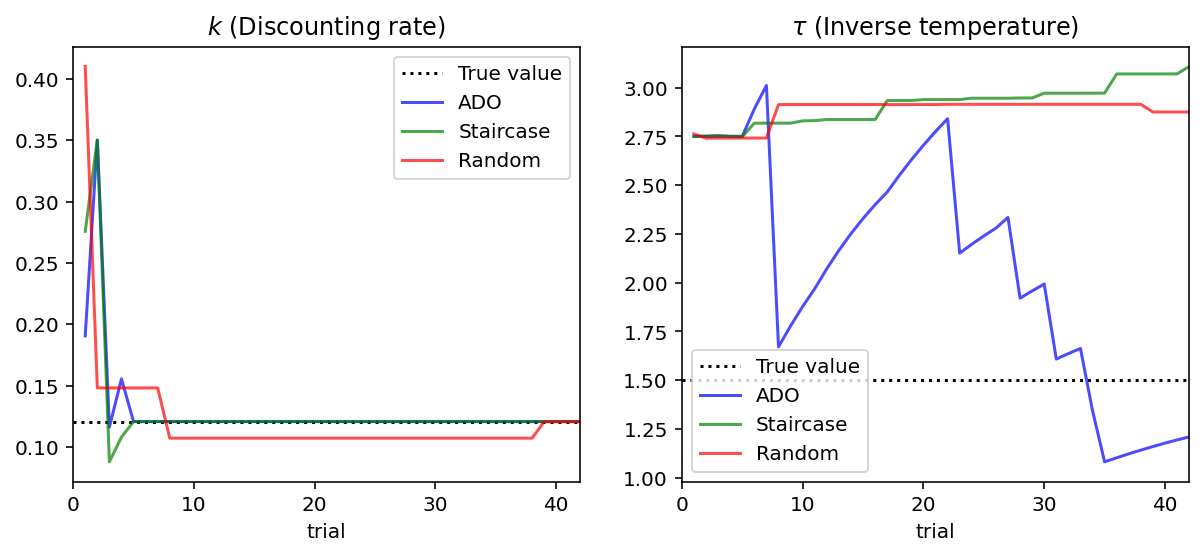

In [19]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
from matplotlib import pyplot as plt

fig, ax = plt.subplots(1, 2, figsize = [10, 4])

# Draw black dotted lines for true parameters
for i, param in enumerate(['k', 'tau']):
    ax[i].axhline(PARAM_TRUE[param], color='black', linestyle=':')

for i, design_type in enumerate(['ADO', 'staircase', 'random']):
    df_cond = df_simul.loc[df_simul['design_type'] == design_type]
    line_color = ['blue', 'green', 'red'][i]
    ax = df_cond.plot(x='trial', y=['mean_k', 'mean_tau'], ax=ax,
                      subplots=True, legend=False, color = line_color, alpha = 0.7)

# Set titles and limits on y axes.
ax[0].set_title('$k$ (Discounting rate)')
ax[1].set_title('$\\tau$ (Inverse temperature)')

ax[0].legend(['True value', 'ADO', 'Staircase', 'Random'])
ax[1].legend(['True value', 'ADO', 'Staircase', 'Random'])
    
plt.show()

## References

Green, L. & Myerson, J. (2004). A discounting framework for choice with delayed and probabilistic rewards. Psychological Bulletin, 130, 769–792.

Mazur, J. E. (1987). An adjusting procedure for studying delayed reinforcement. Commons, ML.; Mazur, JE.; Nevin, JA, 55–73.
